In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class FTIRDataProcessor:
    def __init__(self, csv_path):
        """FTIR CSV 데이터 로드"""
        self.df = pd.read_csv(csv_path, index_col=0)
        self.labels = self.df.index.tolist()
        self.wavenumbers = self.df.columns.astype(float).tolist()
        self.spectra = self.df.values

        # NaN 처리
        self.spectra = np.nan_to_num(self.spectra, nan=0.0)

        # 레이블 인코딩
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def get_raw_features(self):
        """Raw FTIR 스펙트럼 반환"""
        return self.spectra

    def generate_spectrum_image(self, spectrum, save_path=None, dpi=100):
        """스펙트럼을 이미지로 변환"""
        fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=dpi)
        ax.plot(self.wavenumbers, spectrum, linewidth=1.5, color='blue')
        ax.set_xlim(max(self.wavenumbers), min(self.wavenumbers))
        ax.axis('off')
        plt.tight_layout(pad=0)

        # 이미지로 변환
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        plt.close()

        if save_path:
            img.save(save_path)

        return img

    def prepare_dual_modality_data(self):
        """Dual-modality 데이터 준비"""
        images = []
        for spectrum in self.spectra:
            img = self.generate_spectrum_image(spectrum)
            images.append(img)

        return self.spectra, images, self.encoded_labels

# 데이터 로드
processor = FTIRDataProcessor('/content/drive/MyDrive/urp/merged_filtered_cut650_sg.csv')
raw_spectra, spectrum_images, labels = processor.prepare_dual_modality_data()

print(f"Raw spectra shape: {raw_spectra.shape}")
print(f"Number of images: {len(spectrum_images)}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {processor.label_encoder.classes_}")

Raw spectra shape: (1709, 3351)
Number of images: 1709
Labels shape: (1709,)
Classes: ['Cellulose acetate' 'EPR' 'Morphotype 1' 'PA' 'PE' 'PEVA' 'PP' 'PS']


In [4]:
class DualModalityDataset(Dataset):
    def __init__(self, raw_spectra, images, labels, transform=None):
        self.raw_spectra = raw_spectra
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        raw = torch.FloatTensor(self.raw_spectra[idx])
        img = self.images[idx]

        if self.transform:
            img = self.transform(img)

        label = torch.LongTensor([self.labels[idx]])

        return raw, img, label

# 이미지 전처리 (ResNet18용)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [5]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        # 마지막 FC layer 제거
        self.features = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # (batch, 512)
        return x

# 모델 초기화
feature_extractor = ResNet18FeatureExtractor(pretrained=True).to(device)
feature_extractor.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


ResNet18FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [6]:
def extract_cnn_features(images, model, transform, batch_size=32):
    """CNN으로 이미지 feature 추출"""
    model.eval()
    features_list = []

    # Dataset 생성
    temp_dataset = []
    for img in images:
        temp_dataset.append(transform(img))

    # DataLoader 생성
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in temp_loader:
            batch = batch.to(device)
            features = model(batch)
            features_list.append(features.cpu().numpy())

    return np.vstack(features_list)

# CNN features 추출
print("Extracting CNN features from spectrum images...")
cnn_features = extract_cnn_features(spectrum_images, feature_extractor, transform)
print(f"CNN features shape: {cnn_features.shape}")  # (N, 512)

# Raw spectra 정규화
scaler_raw = StandardScaler()
raw_features_scaled = scaler_raw.fit_transform(raw_spectra)

# CNN features 정규화
scaler_cnn = StandardScaler()
cnn_features_scaled = scaler_cnn.fit_transform(cnn_features)

# Dual-modality: Raw + CNN features 결합
dual_features = np.concatenate([raw_features_scaled, cnn_features_scaled], axis=1)
print(f"Dual-modality features shape: {dual_features.shape}")

Extracting CNN features from spectrum images...
CNN features shape: (1709, 512)
Dual-modality features shape: (1709, 3863)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Train/Test Split (30%로 줄임 - 더 많은 학습 데이터 확보)
X_train, X_test, y_train, y_test = train_test_split(
    dual_features, labels, test_size=0.4, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# 과적합 방지를 위한 ML 모델 정의
models_dict = {
    # Logistic Regression: L2 regularization 강화
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=0.1,  # 더 강한 regularization (작을수록 강함)
            max_iter=1000,
            penalty='l2',
            solver='lbfgs',
            random_state=42
        ))
    ]),

    # SVC: 정규화 + 스케일링
    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(
            kernel='rbf',
            C=1.0,  # regularization parameter
            gamma='scale',  # 자동 조정
            random_state=42
        ))
    ]),

    # Random Forest: Extra Trees보다 안정적
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # 깊이 제한으로 과적합 방지
        min_samples_split=10,  # 노드 분할 최소 샘플 수
        min_samples_leaf=5,  # 리프 노드 최소 샘플 수
        max_features='sqrt',  # 각 분할에서 고려할 특성 수 제한
        random_state=42,
        n_jobs=-1
    ),

    # Extra Trees: 과적합 방지 파라미터 추가
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=10,  # 깊이 제한
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),

    # Decision Tree: 강력한 제약 조건
    'Decision Tree': DecisionTreeClassifier(
        max_depth=5,  # 매우 제한적인 깊이
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42
    )
}

# 모델 학습 및 평가
results = {}
overfitting_check = {}

for name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")

    # 학습
    model.fit(X_train, y_train)

    # 훈련/테스트 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 평가
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    overfit_gap = train_acc - test_acc  # 과적합 정도 측정

    results[name] = test_acc
    overfitting_check[name] = {
        'train': train_acc,
        'test': test_acc,
        'gap': overfit_gap
    }

    print(f"\n📊 Accuracy Metrics:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy : {test_acc:.4f}")
    print(f"  Overfit Gap   : {overfit_gap:.4f}", end="")

    # 과적합 경고
    if overfit_gap > 0.15:
        print(" ⚠️  HIGH OVERFITTING!")
    elif overfit_gap > 0.08:
        print(" ⚠️  Moderate overfitting")
    elif overfit_gap < -0.05:
        print(" ⚠️  Possible underfitting")
    else:
        print(" ✅ Good generalization")

    # Classification Report
    print("\n📋 Test Classification Report:")
    print(classification_report(y_test, y_test_pred,
                                target_names=processor.label_encoder.classes_,
                                digits=4))

    # Confusion Matrix
    print("🔢 Test Confusion Matrix:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    # Cross-validation (훈련 세트에서만)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n🔄 5-Fold Cross-Validation:")
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # CV와 Test 성능 비교
    cv_test_gap = abs(cv_scores.mean() - test_acc)
    if cv_test_gap > 0.05:
        print(f"  ⚠️  CV-Test gap: {cv_test_gap:.4f} (모델이 불안정할 수 있음)")
    else:
        print(f"  ✅ CV-Test gap: {cv_test_gap:.4f} (안정적)")

# 결과 요약
print(f"\n{'='*60}")
print("📈 FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print(f"\n{'Model':<25} {'Train':<8} {'Test':<8} {'Gap':<8} {'Status'}")
print("-" * 60)

for name in sorted(results.keys(), key=lambda x: results[x], reverse=True):
    train = overfitting_check[name]['train']
    test = overfitting_check[name]['test']
    gap = overfitting_check[name]['gap']

    # 상태 판단
    if gap > 0.15:
        status = "⚠️  Overfit"
    elif gap > 0.08:
        status = "⚠️  Moderate"
    elif gap < -0.05:
        status = "⚠️  Underfit"
    else:
        status = "✅ Good"

    print(f"{name:<25} {train:.4f}  {test:.4f}  {gap:+.4f}  {status}")

# 최적 모델 추천
print(f"\n{'='*60}")
print("💡 RECOMMENDATIONS")
print(f"{'='*60}")

# Test accuracy 기준 최고 모델
best_by_acc = max(results.items(), key=lambda x: x[1])
print(f"🏆 Best Test Accuracy: {best_by_acc[0]} ({best_by_acc[1]:.4f})")

# 일반화 성능이 가장 좋은 모델 (작은 gap)
best_by_generalization = min(overfitting_check.items(),
                              key=lambda x: abs(x[1]['gap']))
print(f"✅ Best Generalization: {best_by_generalization[0]} "
      f"(gap: {best_by_generalization[1]['gap']:+.4f})")

# 추가 제안
print(f"\n💡 Next Steps:")
if any(v['gap'] > 0.15 for v in overfitting_check.values()):
    print("  • 과적합이 심한 모델들이 있습니다.")
    print("  • 다음을 시도해보세요:")
    print("    - 더 많은 학습 데이터 수집")
    print("    - Regularization 파라미터 강화 (C 값 줄이기)")
    print("    - 특성 선택 또는 차원 축소 (PCA, feature selection)")
    print("    - Dropout 또는 Early Stopping (신경망의 경우)")
else:
    print("  ✅ 모든 모델이 적절한 일반화 성능을 보입니다!")
    print("  • 하이퍼파라미터 튜닝으로 성능을 더 개선할 수 있습니다.")
    print("  • GridSearchCV 또는 RandomizedSearchCV를 시도해보세요.")

Training samples: 1025, Test samples: 684

Training Logistic Regression...

📊 Accuracy Metrics:
  Train Accuracy: 1.0000
  Test Accuracy : 0.9737
  Overfit Gap   : 0.0263 ✅ Good generalization

📋 Test Classification Report:
                   precision    recall  f1-score   support

Cellulose acetate     1.0000    1.0000    1.0000        22
              EPR     0.8500    0.8500    0.8500        20
     Morphotype 1     0.9545    0.9545    0.9545        22
               PA     1.0000    0.8750    0.9333         8
               PE     0.9749    0.9859    0.9804       355
             PEVA     1.0000    0.7647    0.8667        17
               PP     0.9762    0.9809    0.9785       209
               PS     1.0000    1.0000    1.0000        31

         accuracy                         0.9737       684
        macro avg     0.9695    0.9264    0.9454       684
     weighted avg     0.9739    0.9737    0.9733       684

🔢 Test Confusion Matrix:
[[ 22   0   0   0   0   0   0   0]
 [  0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔄 5-Fold Cross-Validation:
  CV Scores: [0.84878049 0.83902439 0.87317073 0.83414634 0.85365854]
  Mean: 0.8498 (±0.0136)
  ✅ CV-Test gap: 0.0172 (안정적)

📈 FINAL RESULTS SUMMARY

Model                     Train    Test     Gap      Status
------------------------------------------------------------
Extra Trees               0.9971  0.9766  +0.0205  ✅ Good
Random Forest             0.9971  0.9751  +0.0219  ✅ Good
Logistic Regression       1.0000  0.9737  +0.0263  ✅ Good
SVC                       0.9883  0.9664  +0.0219  ✅ Good
Decision Tree             0.9161  0.8670  +0.0491  ✅ Good

💡 RECOMMENDATIONS
🏆 Best Test Accuracy: Extra Trees (0.9766)
✅ Best Generalization: Extra Trees (gap: +0.0205)

💡 Next Steps:
  ✅ 모든 모델이 적절한 일반화 성능을 보입니다!
  • 하이퍼파라미터 튜닝으로 성능을 더 개선할 수 있습니다.
  • GridSearchCV 또는 RandomizedSearchCV를 시도해보세요.


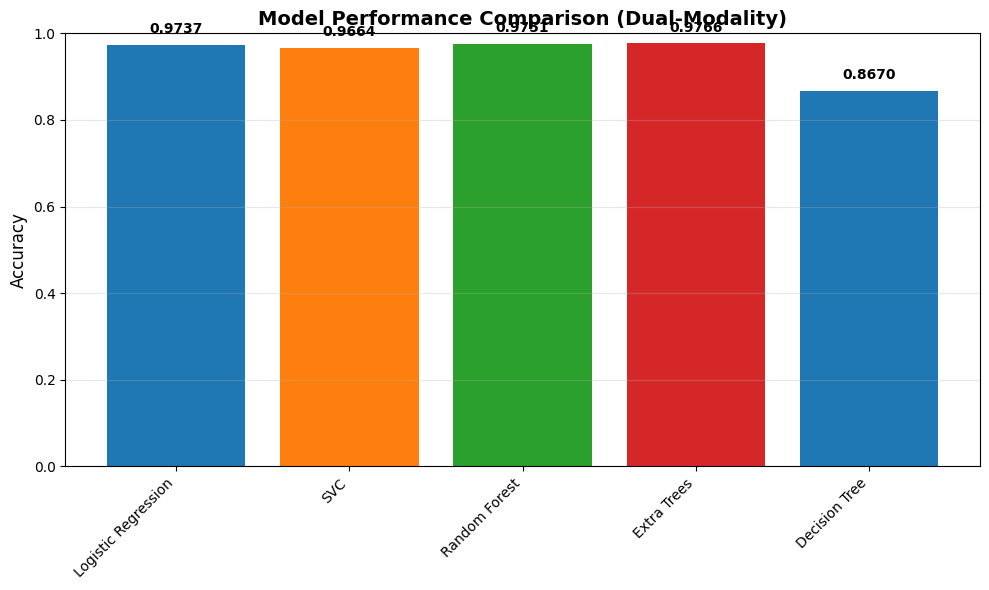

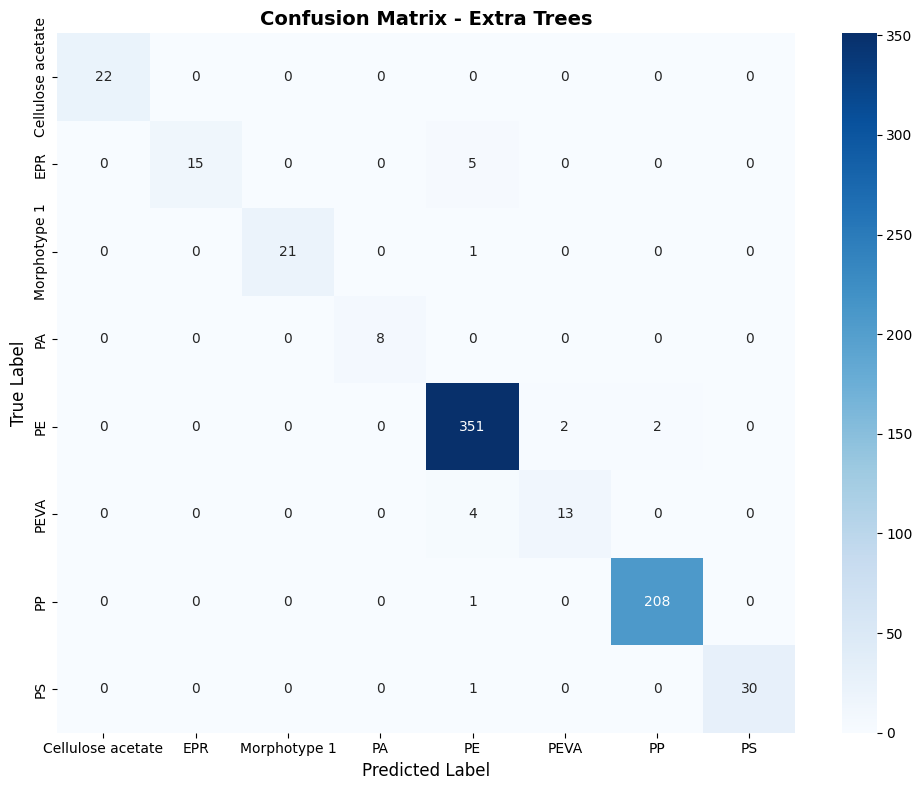

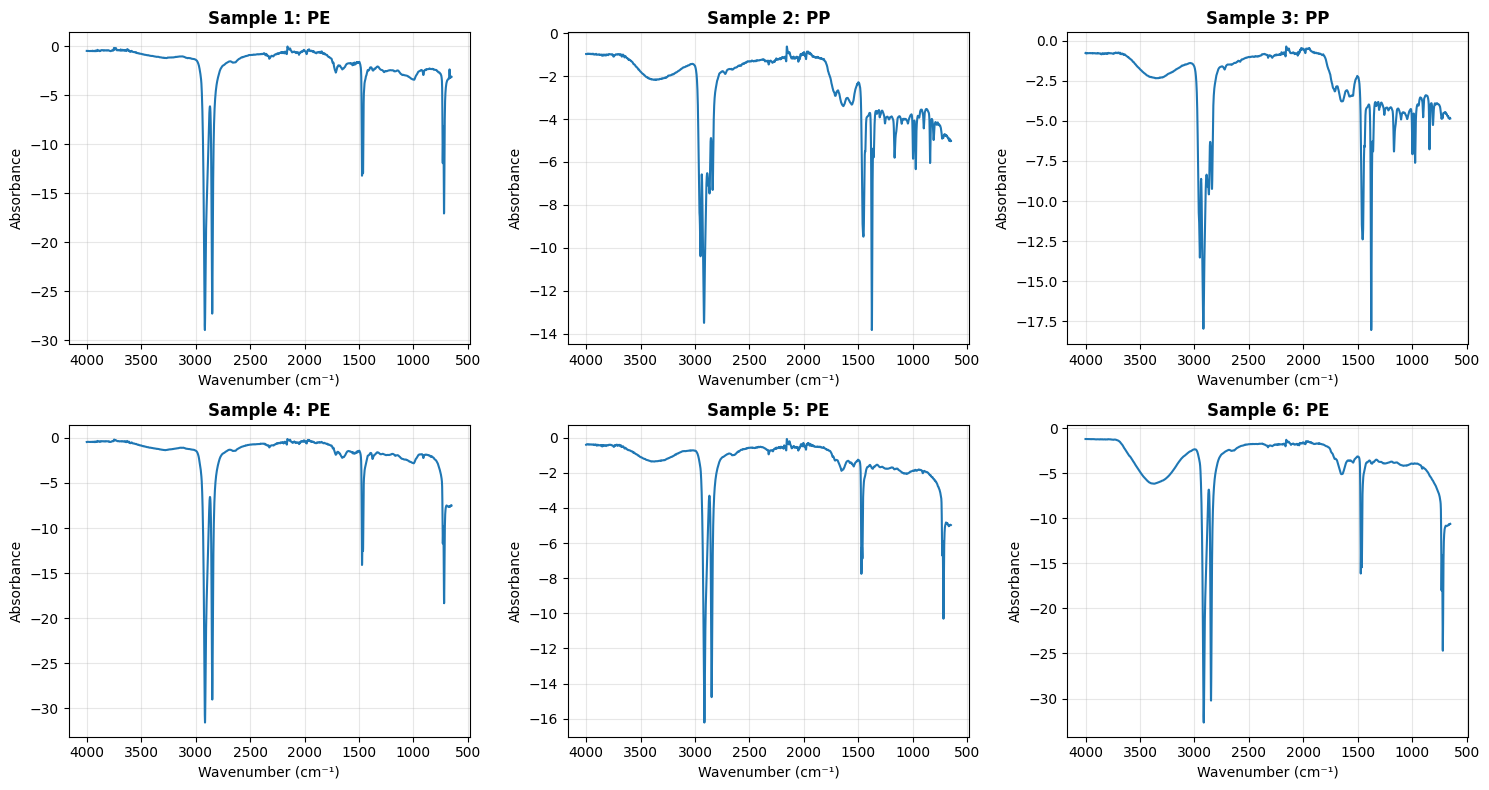

In [8]:
import seaborn as sns

# 1. 모델 성능 비교
plt.figure(figsize=(10, 6))
models_names = list(results.keys())
accuracies = list(results.values())

plt.bar(models_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison (Dual-Modality)', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# 2. Confusion Matrix (최고 성능 모델)
best_model_name = max(results, key=results.get)
best_model = models_dict[best_model_name]
y_pred_best = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=processor.label_encoder.classes_,
            yticklabels=processor.label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_best.png', dpi=300)
plt.show()

# 3. 샘플 스펙트럼 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx in range(6):
    if idx < len(raw_spectra):
        axes[idx].plot(processor.wavenumbers, raw_spectra[idx], linewidth=1.5)
        axes[idx].set_title(f'Sample {idx+1}: {processor.labels[idx]}', fontweight='bold')
        axes[idx].set_xlabel('Wavenumber (cm⁻¹)')
        axes[idx].set_ylabel('Absorbance')
        axes[idx].invert_xaxis()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sample_spectra.png', dpi=300)
plt.show()

In [9]:
import joblib

# 최고 성능 모델 저장
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
joblib.dump(scaler_raw, 'scaler_raw.pkl')
joblib.dump(scaler_cnn, 'scaler_cnn.pkl')
joblib.dump(processor.label_encoder, 'label_encoder.pkl')
torch.save(feature_extractor.state_dict(), 'resnet18_feature_extractor.pth')

print(f"\n✅ Models saved successfully!")
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")


✅ Models saved successfully!
Best model: Extra Trees (Accuracy: 0.9766)
